In [1]:
import os
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import itertools
import glob
import random

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
from keras import callbacks, optimizers
from keras.metrics import top_k_categorical_accuracy
from keras.preprocessing.image import ImageDataGenerator

import capsulenet

np.set_printoptions(precision=2)

%matplotlib inline

Using TensorFlow backend.


In [2]:
def top2(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

def top3(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top4(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=4)

def top5(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

def train_generator(x, y, batch_size, shift_fraction=0.):
        train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
                                           height_shift_range=shift_fraction)
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            yield ([x_batch, y_batch], [y_batch, x_batch])
            
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(np.sqrt(num))
    height = int(np.ceil(float(num)/width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]), dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image

# Creating Dataset

The dataset is created from QuickDraw dataset open sourced by Google at <a href="https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap?pli=1">this link</a>. There is more than 300 categories with around 100k images drawn for every classes. Drawing are done by humans usign mouse so the complevity is higher than MNIST. To do this dataset, we will use 20 classes quite similar an try a classification on it. In term of size, the dataset will be composed of 20 classes with 20k observations for the training, 20 x 5k for test and validation.

Code is commented as matrice is already saved.

In [ ]:
# n_class = 20
# n_train = 20000
# n_test = 5000
# n_val = 5000

# X_train = np.empty((n_class*n_train, 784), dtype=np.uint8, order='C')
# X_test =  np.empty((n_class*n_test,  784), dtype=np.uint8, order='C')
# X_val =   np.empty((n_class*n_val,   784), dtype=np.uint8, order='C')
# y_train = np.empty((n_class*n_train,   1), dtype='U25', order='C')
# y_test =  np.empty((n_class*n_test,    1), dtype='U25', order='C')
# y_val =   np.empty((n_class*n_val,     1), dtype='U25', order='C')

# for i, file in enumerate(glob.glob("F:/Nicolas/PycharmProjects/machine_learning/datasets/Google_Quickdraw/raw/*.npy")):
#     label = file[4:-4]
#     img = np.load(file)
#     n_observation, n_feature = img.shape
#     idx = random.sample(range(n_observation), n_train+n_test+n_val) # not np.random.randint(n_observation, size=n_train+n_test+n_val) to avoid double
#     X_train[i*n_train:(i+1)*n_train] = img[idx[:n_train]]
#     X_test[ i*n_test:(i+1)*n_test] = img[idx[n_train:n_train+n_test]]
#     X_val[  i*n_val:(i+1)*n_val] = img[idx[-n_val:]]
#     y_train[i*n_train:(i+1)*n_train] = label
#     y_test[ i*n_test:(i+1)*n_test] = label
#     y_val[  i*n_val:(i+1)*n_val] = label

# X_train, y_train = shuffle(X_train, y_train)
# X_test, y_test = shuffle(X_test, y_test)
# X_val, y_val = shuffle(X_val, y_val)

# np.savez_compressed("F:/Nicolas/PycharmProjects/machine_learning/datasets/Google_Quickdraw/prepared/dataset.npz", 
#                     X_train=X_train, 
#                     y_train=y_train, 
#                     X_test=X_test,
#                     y_test=y_test,
#                     X_val=X_val,
#                     y_val=y_val)

# Loading and dataset preparation

Let's now load it, explore it and try a simple CNN and a Capsule Network model to compare both performances.

In [3]:
dataset = np.load("F:/Nicolas/PycharmProjects/machine_learning/datasets/Google_Quickdraw/prepared/dataset.npz")
X_train=dataset["X_train"]
y_train=dataset["y_train"]
X_test=dataset["X_test"]
y_test=dataset["y_test"]
X_val=dataset["X_val"]
y_val=dataset["y_val"]

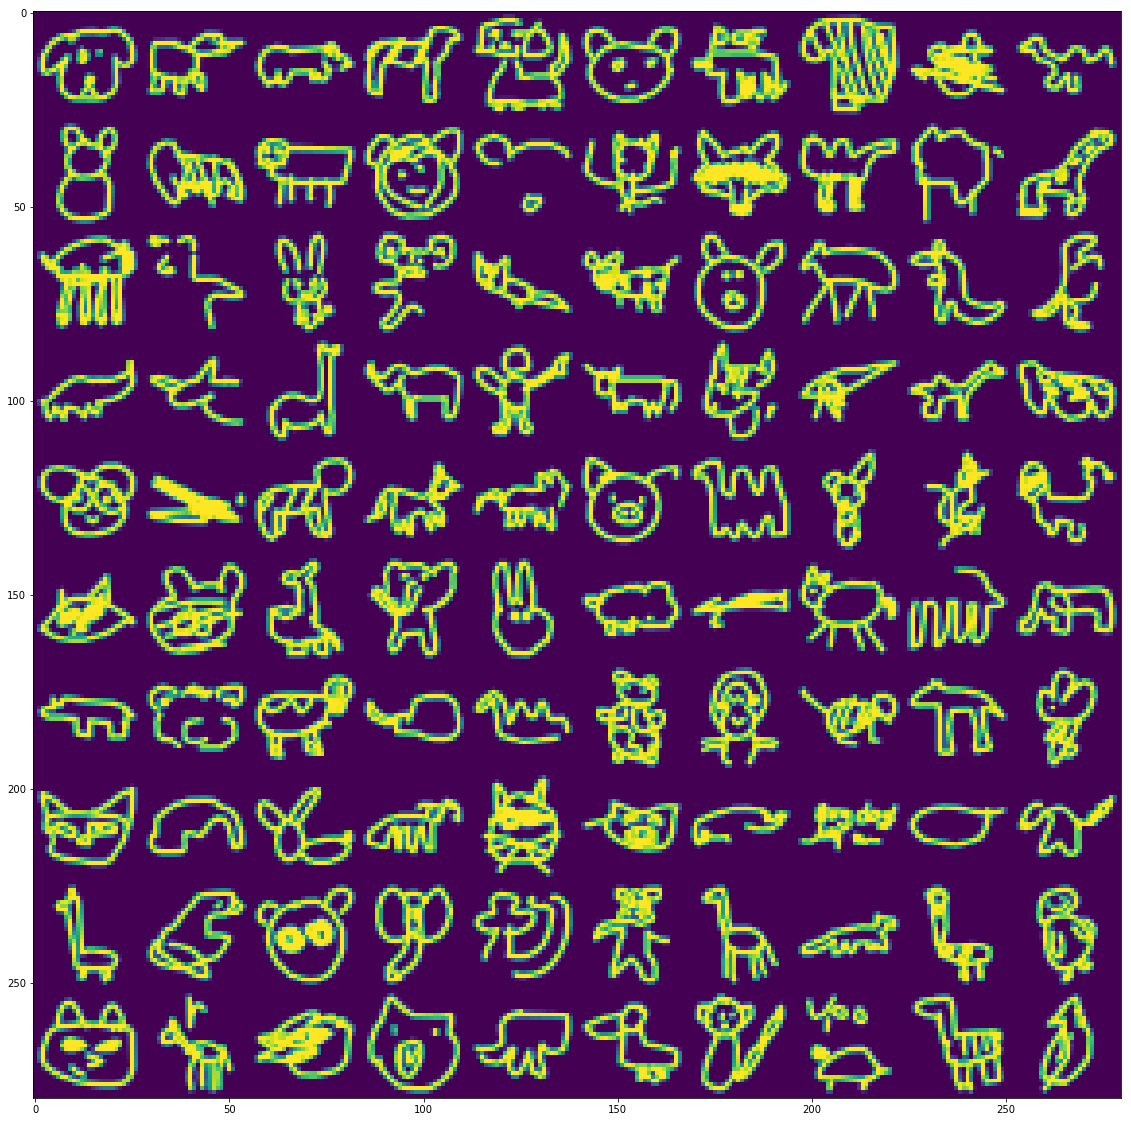

In [4]:
img = combine_images(X_train[:100].reshape(100, 28, 28, 1))

plt.figure(figsize=(20,20))
plt.imshow(img)
plt.show()

We can see that some drawings are not finalized as the software stop recording images as soon as it found the correct answer. Moreover, we can see multiple representation for the same classe. We have drawing of the face or the animal from the side. This create more complexity and we will see how Machine Learning can perform on this kind of dataset.

In [5]:
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

In [6]:
X_train = X_train.reshape(-1, img_rows, img_cols, 1)
X_test = X_test.reshape(-1, img_rows, img_cols, 1)
X_val = X_val.reshape(-1, img_rows, img_cols, 1)

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_val = X_val.astype('float32') / 255.

In [7]:
encoder = LabelBinarizer()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
y_val = encoder.transform(y_val)
joblib.dump(encoder, 'LabelBinarizer.pkl') 

['LabelBinarizer.pkl']

# Simple CNN

Let's first try a Classic CNN but with more depth as there is more complex features to learn compare to MNIST.

In [8]:
batch_size = 200
num_classes = 20
epochs = 6

In [9]:
model = Sequential()
model.add(Conv2D(filters=64, 
                 kernel_size=(3, 3),
                 strides=1,
                 padding="SAME",
                 activation='relu',
                 input_shape=input_shape,
                 name="conv1"
                ))
model.add(Conv2D(filters=128, 
                 kernel_size=(3, 3), 
                 strides=1,
                 padding="SAME",
                 activation='relu', 
                 name="conv2"
                ))
model.add(MaxPooling2D(pool_size=(2, 2), name="MaxPool"))
model.add(Conv2D(filters=256, 
                 kernel_size=(3, 3), 
                 strides=1,
                 padding="SAME",
                 activation='relu', 
                 name="conv3"
                ))
model.add(Conv2D(filters=256, 
                 kernel_size=(3, 3), 
                 strides=1,
                 padding="SAME",
                 activation='relu', 
                 name="conv4"
                ))
model.add(MaxPooling2D(pool_size=(2, 2), name="MaxPool2"))
model.add(Conv2D(filters=512, 
                 kernel_size=(3, 3), 
                 strides=1,
                 padding="VALID",
                 activation='relu', 
                 name="conv5"
                ))
model.add(Conv2D(filters=512, 
                 kernel_size=(3, 3), 
                 strides=1,
                 padding="VALID",
                 activation='relu', 
                 name="conv6"
                ))

model.add(Dropout(0.25))
model.add(Flatten(name="flat"))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 28, 28, 64)        640       
_________________________________________________________________
conv2 (Conv2D)               (None, 28, 28, 128)       73856     
_________________________________________________________________
MaxPool (MaxPooling2D)       (None, 14, 14, 128)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 14, 14, 256)       295168    
_________________________________________________________________
conv4 (Conv2D)               (None, 14, 14, 256)       590080    
_________________________________________________________________
MaxPool2 (MaxPooling2D)      (None, 7, 7, 256)         0         
_________________________________________________________________
conv5 (Conv2D)               (None, 5, 5, 512)         1180160   
__________

In [10]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=["accuracy", top2, top3, top4, top5])

In [ ]:
# model.fit(X_train, y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           verbose=1,
#           validation_data=(X_test, y_test))
# model.save_weights('trained_model_cnn.h5')

The training has been stopped when loss was becoming constant after a bit more than 8 epochs. Several topologies have been tried (more or less deep or wide) and the result on this model is quite good without overfitting. We can see it by evaluating the validation dataset.

In [11]:
model.load_weights('trained_model_cnn.h5')

score = model.evaluate(X_val, y_val, verbose=1)
print('Test loss: {:.3f}'.format(score[0]))
for i in range(1, 6):
    print('Top {}: {:.3f}%'.format(i, score[i]))

100000/100000 [==============================] - 23s 230us/step
Test loss: 0.697
Top 1: 0.788%
Top 2: 0.886%
Top 3: 0.925%
Top 4: 0.946%
Top 5: 0.959%


In [12]:
y_pred = model.predict(X_val)

In [13]:
percent = y_pred.max(axis=1)
y_pred_rank = np.apply_along_axis(lambda x:(x == max(x)).astype(np.uint8), axis=1, arr=y_pred)

In [14]:
label_pred = encoder.inverse_transform(y_pred_rank)
label_true = encoder.inverse_transform(y_val)

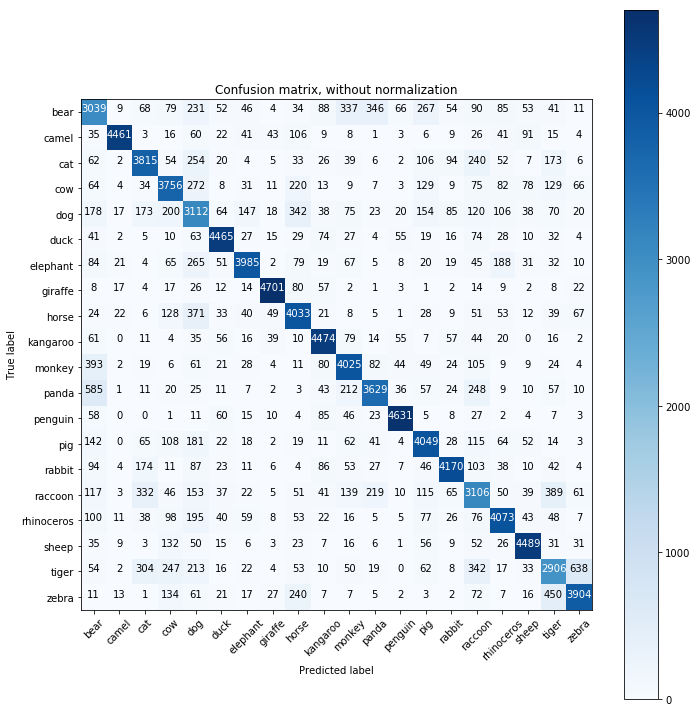

In [31]:
cnf_matrix = confusion_matrix(label_true, label_pred, labels=encoder.classes_ )

plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=encoder.classes_, title='Confusion matrix, without normalization')
plt.show()

The main bucket of error is for: 
<ul>
    <li>tiger (58% success) 
        <ul>
            <li>12.7% are categorized as zebras</li>
            <li>6.8% are categorized as raccon</li>
            <li>6.1% are categorized as cat</li>
        </ul>
    </li>
    <li>bear (60% success)   
        <ul>
            <li>6.9% are categorized as panda</li>
            <li>6.7% are categorized as monkey</li>
            <li>5.3% are categorized as pig</li>
        </ul>
    </li>
    <li>raccoon (62% success)     
        <ul>
            <li>7.8% are categorized as tiger</li>
            <li>6.6% are categorized as cat</li>
            <li>4.3% are categorized as panda</li>
        </ul>
    </li>
    <li>dog (62% success)    
        <ul>
            <li>6.8% are categorized as horse</li>
            <li>4% are categorized as cow</li>
            <li>3.5% are categorized as bear</li>
        </ul>
    </li>
    <li>panda (72.5% success)   
        <ul>
            <li>11.7% are categorized as bear</li>
            <li>5% are categorized as raccon</li>
            <li>4.2% are categorized as monkey</li>
        </ul>
    </li>
</ul>

All other classes are very close to the average or above. What we can also see, is the mis-classification is limited to few classes only. For example with panda, with only the 3 main error, we group 93% of element which means that only 7 % are leading to 16 other classes. Let's try to check is Capsule network perform better as they work as ensemble and may avoid some mistakes.

# Capsule Network

The implemantation used to do the capsule network comes from this <a href="https://github.com/XifengGuo/CapsNet-Keras">repository </a>. The training has been done in several parts with reload of previous save as the training is slow (30 min/Epoch with reconstruction)

In [10]:
model, eval_model, manipulate_model = capsulenet.CapsNet(input_shape=X_train.shape[1:],
                                                         n_class=num_classes,
                                                         routings=1)
model.summary()

Instructions for updating:
dim is deprecated, use axis instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 20, 20, 256)  20992       input_1[0][0]                    
__________________________________________________________________________________________________
primarycap_conv2d (Conv2D)      (None, 6, 6, 256)    5308672     conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_reshape (Reshape)    (None, 1152, 8)      0           primarycap_conv2d[0][0]          
______________________________________________

In [11]:
lr = 0.01 # was 0.001
recon = 0 # was 0.392
batch_size = 512
epoch = 10

In [12]:
# capsulenet.train(model=model, data=((X_train, y_train), (X_test, y_test)), args = arg)

model.compile(optimizer=optimizers.Adam(lr=lr),
                  loss=[capsulenet.margin_loss, 'mse'],
                  loss_weights=[1., recon],
                  metrics={'capsnet': 'accuracy'})

lr_decay = keras.callbacks.LearningRateScheduler(schedule=lambda x: lr * (0.9 ** x))

In [13]:
training = False

if training:
    model.load_weights('trained_model_capsnet.h5', by_name=True)  # to restart from previous checkpoint
    model.fit_generator(generator=train_generator(X_train, y_train, batch_size = batch_size, shift_fraction = 0.1),
                        steps_per_epoch= y_train.shape[0] // batch_size,
                        epochs=epoch,
                        validation_data=[[X_test, y_test], [y_test, X_test]],
                        callbacks=[lr_decay])
    model.save_weights('trained_model_capsnet.h5')
else:
    model.load_weights('trained_model_capsnet.h5', by_name=True)

In [49]:
# model.save_weights('trained_model_capsnet.h5')

The training has been stopped after few hours as it took less than 0.2 % of accracy increase in 10 minutes and the accuracy is only 60 %. The mmodel won't reach performances we got previously. This can be explained because we can represent every classes in various way and in this model we end with 20 capsule (1 per class) so it's more difficult to find a consensus of 1 generic representation for every class. It works hightly better with MNIST at all digit are quite similar in term of shape.

In [14]:
y_pred_caps, X_recon = model.predict([X_val, y_val], batch_size=batch_size)

In [15]:
print('Validation acc:', np.mean(np.argmax(y_pred_caps, 1) == np.argmax(y_val, 1)))

percent_caps = y_pred_caps.max(axis=1)
y_pred_rank_caps = np.apply_along_axis(lambda x:(x == max(x)).astype(np.uint8), axis=1, arr=y_pred_caps)

label_pred = encoder.inverse_transform(y_pred_rank_caps)
label_true = encoder.inverse_transform(y_val)

Validation acc: 0.6022


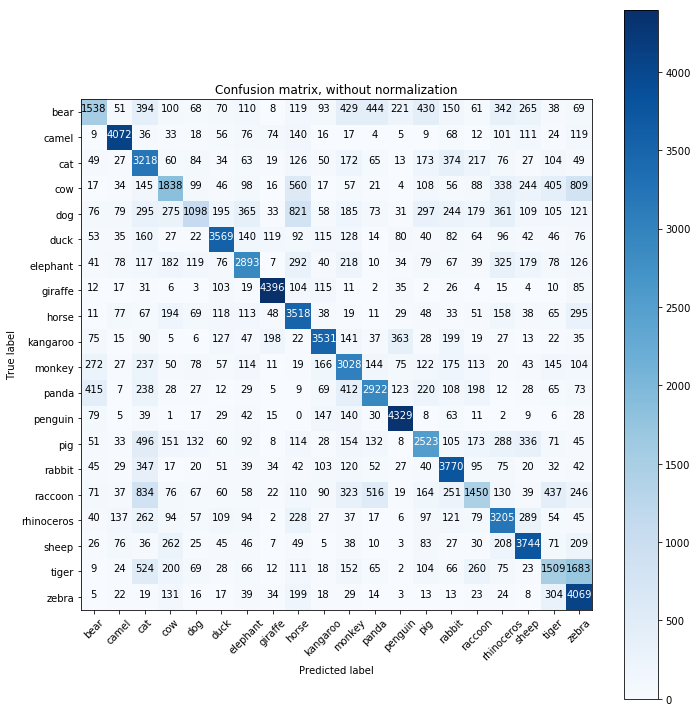

In [16]:
cnf_matrix = confusion_matrix(label_true, label_pred, labels=encoder.classes_ )

plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=encoder.classes_, title='Confusion matrix, without normalization')
plt.show()

As we can expect based on the result of the learning, the result is worse. There is some classes which are successfull (for example giraffe and penguin with around 88%) but a lot have a very bad ratio (like tiger with only 30% and 33% categorized as zebras). So we won't use the CapsNet Model. Before to conclude, let's take a look at some mistakes we have with the previous model.

# Analysis of Mistakes

To do so, let's print the top 10 images where the wrong prediction is the highest.

In [48]:
index_wrong = np.where(np.argmax(y_pred_rank, 1) != np.argmax(y_val, 1))
percent_wrong = percent[index_wrong]
image_wrong = X_val[index_wrong]      # to pre-filter image for second indexing
label_pred_big_mistakes = label_pred[index_wrong]
label_true_big_mistakes = label_true[index_wrong]

index_biggest_mistakes = np.argsort(percent_wrong)[-10:]
percent_wrong = percent_wrong[index_biggest_mistakes]
image_wrong = image_wrong[index_biggest_mistakes]
label_pred_big_mistakes = label_pred_big_mistakes[index_biggest_mistakes]
label_true_big_mistakes = label_true_big_mistakes[index_biggest_mistakes]

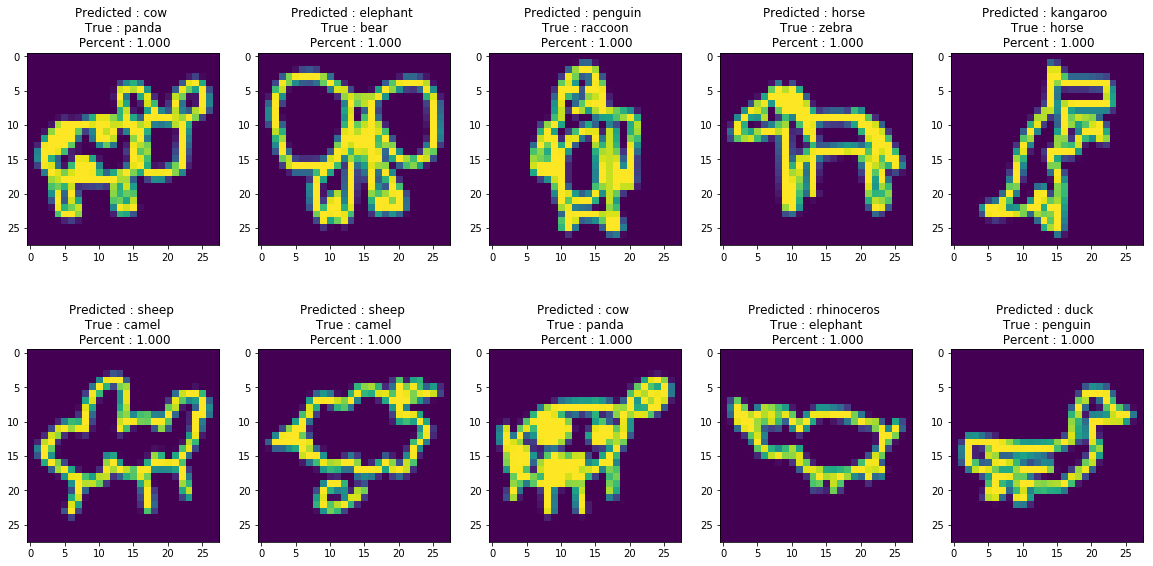

In [58]:
plt.figure(figsize=(20,10))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(image_wrong[i, :, : , 0])
    plt.title("Predicted : {} \n True : {} \n Percent : {:.3f}".format(label_pred_big_mistakes[i], label_true_big_mistakes[i], percent_wrong[i]))
plt.show()

If we ask also a human to classify those images, he will most probably do the same guess as the network (except maybe the 6th one). Those images are extremely close to other one from the expected target as we can see below for example with a sample of duck. 

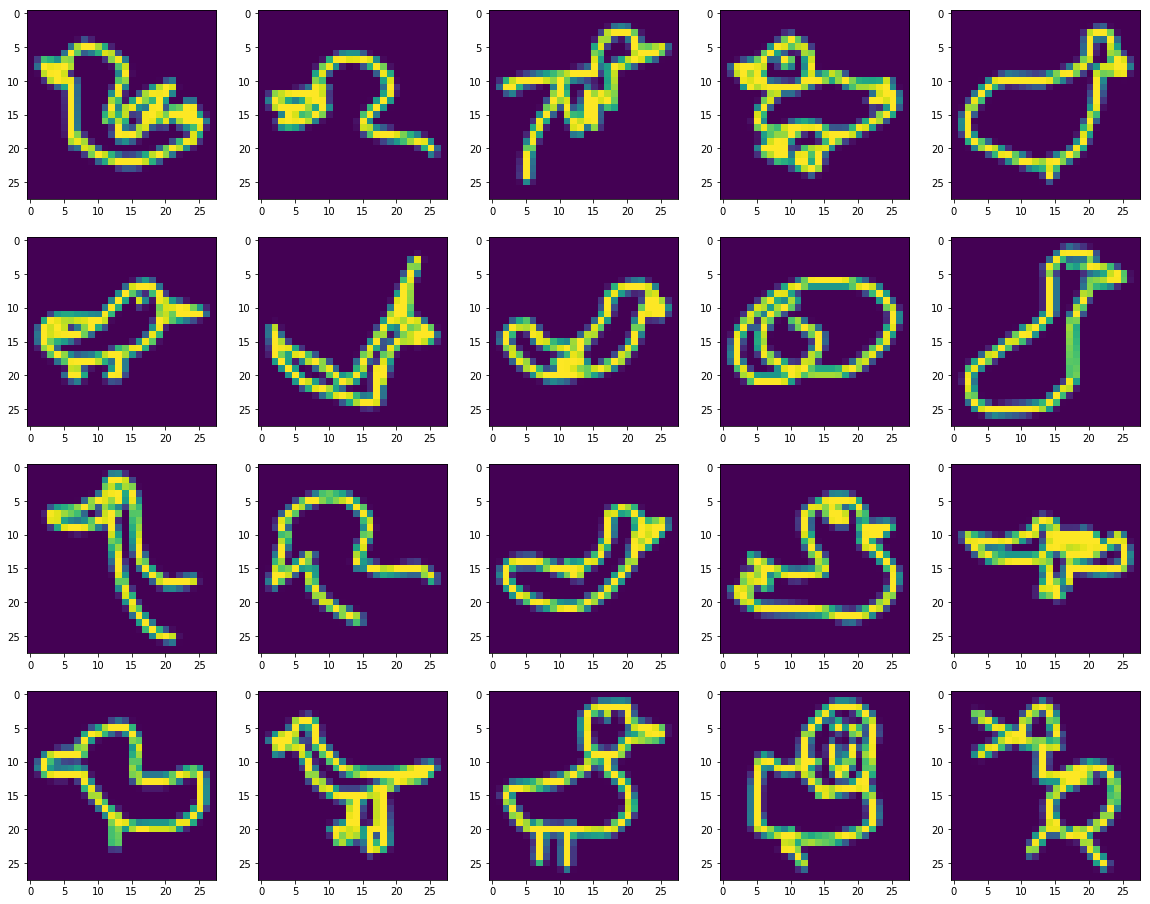

In [71]:
index_duck = np.where(np.argmax(y_val, axis=1) == 5)[:20]
img_duck = X_val[index_duck]

plt.figure(figsize=(20,16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(img_duck[i, :, : , 0])
plt.show()

As mentionned previously, some drawings are not finalized as the Network found the issue before the end of the drawing. But we can still see that the shape is alsways similar

# Conclusion

In this notebook we explore a classification of a dataset more complex than MNIST due to un-finalized drawing and different ways to represent them. After a try of several classical CNN and a test of a Capsule Network, we saw that CNN is still better in this task and a lot faster (by a factor of 18).

In future Notebook, we will continue to work on this dataset with for example a test of GANS with a subset of classes or why not a clustering too. 